# Load and Visualize ISCE outputs

In [1]:
import numpy as np
import rasterio
import iscefunctions as util

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Point to where data is stored
datadir = './data_8lks/'
nlks = '8alks_8rlks'
unwFile = 'filt_topophase.unw.{}.geo.vrt'.format(nlks)
demFile = 'dem.{}.crop.vrt'.format(nlks)
losFile = 'los.rdr.{}.geo.vrt'.format(nlks)
corFile = 'phsig.cor.{}.geo.vrt'.format(nlks)
concompFile = 'filt_topophase.unw.conncomp.{}.geo'.format(nlks)

In [3]:
pCalbuco = (-72.614, -41.326)

In [4]:
# Plot the LOS displacements
data,extent,metadata = util.load_rasterio(datadir + unwFile)
amp,phs = data
mm = phs*55.46576/12.5663706  #For sentinel

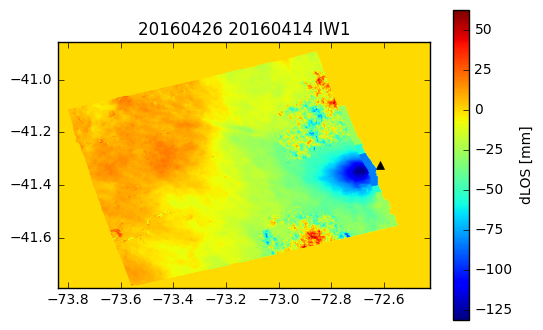

In [5]:
plt.imshow(mm, extent=extent)
plt.plot(pCalbuco[0], pCalbuco[1], 'k^', scalex=False, scaley=False)
cb = plt.colorbar()
plt.title('20160426 20160414 IW1')
cb.set_label('dLOS [mm]')
#print(np.nanmean(mm))

In [17]:
# Check /plot data before modeling
def plot_3(array1,array2,array3):
    ''' plot auxilary files '''
    # a few simple plots
    # http://stackoverflow.com/questions/32633322/changing-aspect-ratio-of-subplots-in-matplotlib
    fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(10,10), subplot_kw=dict(adjustable='box-forced'))
    cs = 0.3 #colorbar shrink (vertical)
    ax = axes[0]
    im = ax.imshow(array1, extent=extent, cmap='viridis')
    plt.colorbar(im, ax=ax, shrink=cs)

    ax = axes[1]
    im = ax.imshow(array2, extent=extent, cmap='viridis')
    plt.colorbar(im, ax=ax, shrink=cs)

    ax = axes[2]
    im = ax.imshow(array3, extent=extent, cmap='viridis')
    plt.colorbar(im, ax=ax, shrink=cs)
    
    #Add a particular point (e.g. Calbuco summit)
    p = (-72.614, -41.326)
    for ax in axes:
        ax.plot(p[0], p[1], 'k^', scalex=False, scaley=False)

In [11]:
data,extent,metadata = util.load_rasterio(datadir + concompFile)
concomp = data[0]
#concomp[concomp==0] = np.nan can't use NaNs with integer arrays
data,extent,metadata = util.load_rasterio(datadir + losFile)
incd, head = data
incd[incd==0] = np.nan
#data,extent,metadata = util.load_rasterio(datadir + 'topophase.cor.geo.vrt')
#amp,cor = data
data,extent,metadata = util.load_rasterio(datadir + corFile)
cor = data[0]
cor[cor==0] = np.nan

/home/scott/miniconda3/envs/cov9/lib/python3.5/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


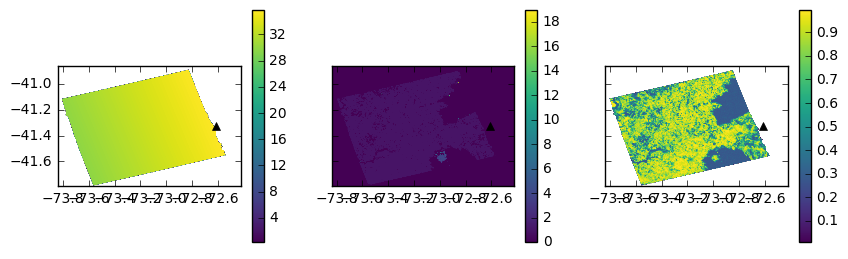

In [18]:
plot_3(incd,concomp,cor)

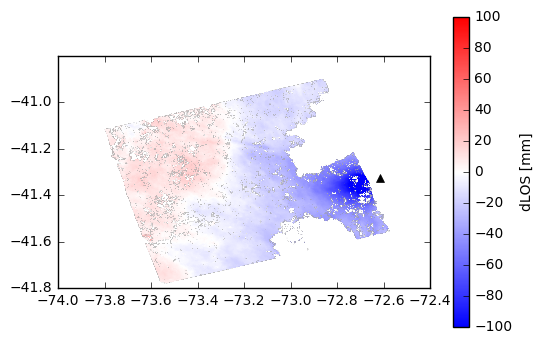

In [20]:
# Apply connected component mask from SNAPHU
mm_m = mm.copy()
mm_m[concomp != 1] = np.nan

norm = plt.cm.colors.Normalize(vmin=-100, vmax=+100) 
plt.imshow(mm_m, extent=extent, norm=norm, cmap='bwr')
plt.plot(pCalbuco[0], pCalbuco[1], 'k^')
cb = plt.colorbar()
cb.set_label('dLOS [mm]')

#plt.savefig('los.pdf', bbox_inches='tight')

In [21]:
# Save masked image back to a georeferenced file
metadata['driver'] = 'GTiff'
util.save_rasterio('filt_topophase_mm_masked.tif', mm_m.astype('f4'), metadata)

/home/scott/miniconda3/envs/cov9/lib/python3.5/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


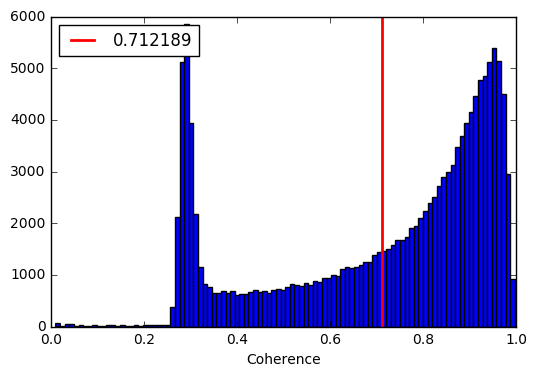

In [22]:
# Histograms too
junk = plt.hist(cor[np.isfinite(cor)], bins=100)
plt.axvline(np.nanmean(cor),color='r',lw=2, label=np.nanmean(cor))
plt.xlabel('Coherence')
plt.legend(loc='upper left')
# NOTE: edge effects create some weird values, should probably mask any values < 35

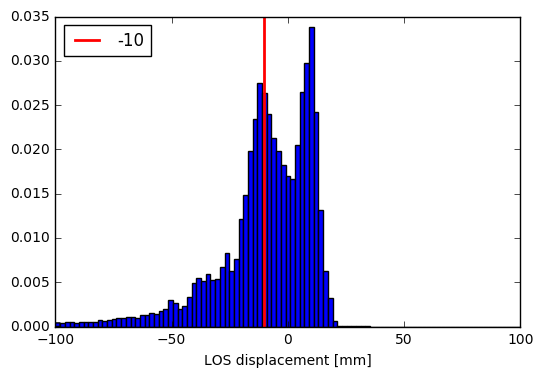

In [23]:
# Histograms too
n, bins, patches = plt.hist(mm_m[np.isfinite(mm_m)], normed=True, bins=np.linspace(-1e2,1e2,100))

mean = np.nanmean(mm_m)
std = np.nanstd(mm_m)

# plot normalized PDF
#y = mlab.normpdf(bins, mean, std)
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.axvline(mean,color='r',lw=2, label=int(mean))
plt.xlabel('LOS displacement [mm]')
plt.legend(loc='upper left')
# NOTE: edge effects create some weird values, could mask them...
plt.savefig('los_displacement_variance.pdf',bbox_inches='tight')

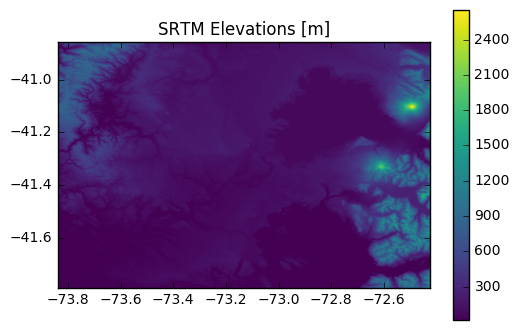

In [24]:
# dem.crop georeferencing information not correct...
data,junk,junk = util.load_rasterio(datadir + demFile)
elev = data[0]
plt.imshow(elev, extent=extent, cmap='viridis')
plt.title('SRTM Elevations [m]')
plt.colorbar()

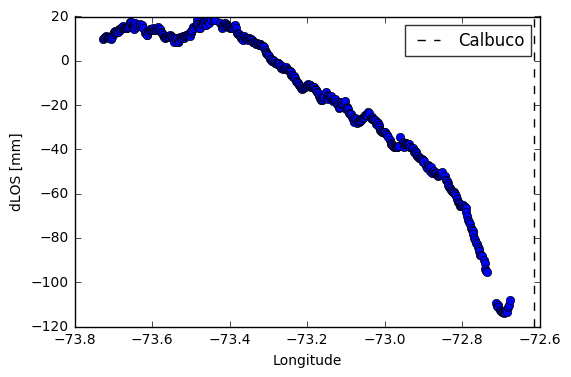

In [25]:
# Profile through a lat-lon point
row,col= util.world2rc(pCalbuco[0], pCalbuco[1], metadata['affine']) #image coordinates of calbuco
lons = np.linspace(extent[0],extent[1],mm_m.shape[1])
profile = mm_m[row,:]

plt.plot(lons, profile, 'bo')
plt.axvline(pCalbuco[0], color='k', linestyle='dashed', label='Calbuco')
plt.xlabel('Longitude')
plt.ylabel('dLOS [mm]')
plt.legend(loc='upper right', frameon=True, framealpha=0.8)